# Data 607 &mdash; Winter 2022 &mdash; Assignment 2

## Instructions

**Submit a .ipynb file and a Colab link to the your solutions to the appropriate D2L dropbox by 23:59 on Wednesday, March 23. For the Colab link, make sure that the permission is set to "Anyone on the internet with this link can view".**

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Synthetic Dataset 1: Binary Classification

Here's some code for generating binary classification data with a nonlinear decision boundary:

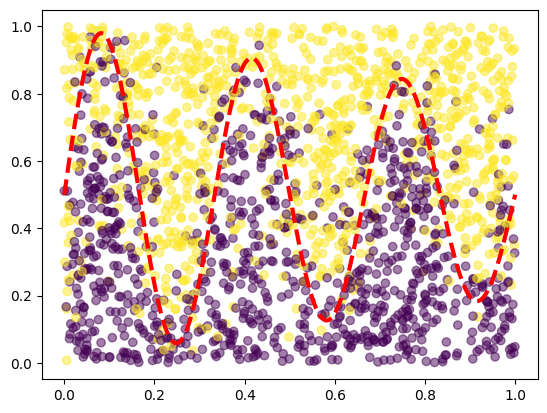

In [2]:
def make_two_class_data(n, random_state=None):
  def f(x):
    return 0.5*(np.sin(2*np.pi*3*x)*np.exp(-0.5*x) + 1)

  if random_state is not None:
    np.random.seed(42)

  X = np.random.uniform(size=(n, 2))
  e0 = 0.05*np.random.normal(size=n)
  e1 = 0.05*np.random.normal(size=n)
  y = X[:,1] + e1 > f(X[:,0] + e0)

  return X, y

X, y = make_two_class_data(2000, random_state=42)
plt.scatter(*X.T, c=y, alpha=0.5)
t = np.linspace(0, 1, 1000)
plt.plot(t, 0.5*(np.sin(2*np.pi*3*t)*np.exp(-0.5*t) + 1), "r--", lw=3)
plt.show()

## Synthetic Dataset 2: 3-Class Classification

Here's some code for generating 3-class classification data:

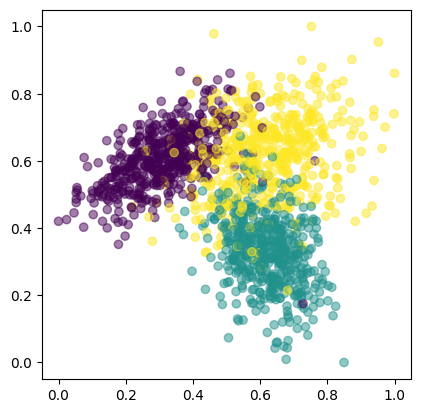

In [3]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

def make_three_class_data(n, random_state=None):
  X, y = make_classification(
      n_classes=3,
      n_samples=n,
      n_features=2,
      n_informative=2,
      n_redundant=0,
      n_clusters_per_class=1,
      class_sep=1.0,
      random_state=random_state)

  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  return X, y

X, y = make_three_class_data(1500, random_state=43)
plt.scatter(*X.T, c=y, alpha=0.5)
plt.gca().set_aspect("equal")

## Exercise 1: Gaussian Bayes Classifier

1. Implement the Gaussian Bayes classifier (as described in Lecture 4) as a scikit-learn estimator by fleshing class skeleton included below.

  Your estimator should support $K$-class classification, not just binary classification.

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class GaussianBayes(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    X, y = check_X_y(X, y)
    self.classes_ = unique_labels(y)
    # your code here
    return self

  def predict(self, X):
    check_is_fitted(self)
    X = check_array(X)
    # your code here


2. Apply your `GaussianBayes` estimator to Synthetic Dataset 2: Fit your model to the training data and predict class labels for the testing data. (Use the data splitting provided below.) Plot the decision regions, overlaid with the a scatter plot of the dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X, y = make_three_class_data(1500, random_state=44)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.8, random_state=45)

3. Repeat part 2. with `sklearn.naive_bayes.GaussianNB` in place of your own `GaussianBayes`.

## Exercise 2: Kernel Classification

Let $W(x,x_i)$ be a weight function, as in our discussion of kernel regression from Lecture 4.

Suppose we're given training data for a $K$-class classification problem,

$$
(x_1,y_1),\ldots,(x_n,y_n),
$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\{0,\ldots,K-1\}$.

For each test point $x\in\mathbb{R}^p$ and each class $k\in\{0,\ldots,K-1\}$, let $W_k(x)$ be the sum of the weights $W(x,x_i)$ associated to training examples $(x_i, y_i)$ with $y_i=k$:

$$
W_k(x) = \sum_{\begin{smallmatrix}i=1\\ y_i=k\end{smallmatrix}}^n W(x,x_i)
$$

Define a corresponding classification rule by assigning $x$ to the class $k$ for which $W_k(x)$ is largest:

$$
f(x) = \operatorname*{arg\,max}_{0\leq k<K} W_k(x)
$$

This entire discussion applies when the weight function $W(x,x_i)$ arises from a kernel function $K$ and a bandwidth parameter $h$, as in Lecture 4:

$$
W(x, x_i) = \frac{K(\|x - x_i\|/h)}{\sum_{j=1}^n K(\|x - x_j\|/h)}
$$

The resulting classifier is called a **kernel classifier**.

1. Implement the kernel classifier as a scikit-learn estimator by fleshing out the `predict` method of the class skeleton included below. (Don't touch the `__init__` and `fit` methods.) Your classifier should pass the `check_estimator` test. Two bonus points if you can do this without using loops or their close cousins (e.g., comprehensions).

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

def G(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

class KernelClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, K=G, h=1):
        self.K = K
        self.h = h

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = unique_labels(y)
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        # your code here

check_estimator(KernelClassifier())

2. Apply your code to Synthetic Dataset 1. Use `GridSearchCV` on to find optimal values for the bandwidth parameter $h$. For that value of $h$, plot the decision regions and report the error on the test set.

In [ ]:
X_tr, y_tr = make_two_class_data(2000, random_state=46)
X_te, y_te = make_two_class_data(2000, random_state=47)

3. Apply your code to Synthetic Dataset 2. Use `GridSearchCV` on to find optimal values for the bandwidth parameter $h$. For that value of $h$, plot the decision regions and report the error on the test set.

In [ ]:
X_tr, y_tr = make_three_class_data(1500, random_state=48)
X_te, y_te = make_three_class_data(1500, random_state=49)

## Exercise 3: Spam Detection

- In this exercise, we use Bayes and na&iuml;ve Bayes classifiers to classify text message spam.

- We use a dataset from the UCI machine learning repository. Details can be found here [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

- For our convenience, I'm hosting the data file on my github page.

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/mgreenbe/spam/main/spam.csv"
df = pd.read_csv(url, encoding="latin-1")
df.rename(columns={"v1": "label", "v2": "message"}, inplace=True)
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


1. Split the data into a training set (80% of the data) and a testing set (20% of the data). Compute the proportions of ham and spam in the training set.

2. Add a feature column **length** to the dataframe `df` containing the lengths of the messages, in characters. Classify the messages in the test set as ham/spam using a Gaussian (na&iuml;ve) Bayes classifier trained on the length data. Record the associated testing error.

  Repeat this exercise with **caps**, the number of capital letters in a message, and **misc**, the number of characters in a message that aren't letters, digits, or spaces.

  (Since each of the classifiers in this part only considers a single feature, there is no distinction between Bayes and na&iuml;ve Bayes.)

3. Construct a **Gaussian na&iuml;ve Bayes** classifier to the (**length**, **caps**, **misc**) data. Compare its performance to those considered in part (2).

4. Construct a **Gaussian Bayes** classifier by fitting a 3-dimensional Gaussian distribution to the (**length**, **caps**, **misc**) data. Feel free to use your above implementation of `GaussianBayes` here. Compare its performance to the na&iuml;ve version considered in part (3). Comment.

5. Repeat part (2) with **digits**, the number of digits in a message. Comment.

6. Construct a **multinomial na&iuml;ve Bayes** classifier using frequency data as produced by `CountVectorizer`. Compare its performance to those considered above.